In [1]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts

### Load data

In [2]:
data_dir = '../data/'

In [3]:
# load TCGA info and alignment weights

tcga_unlabeled_info_dir = data_dir + 'TCGA/TCGA_unlabeled_info.csv'
tcga_unlabeled_info_df = pd.read_csv(tcga_unlabeled_info_dir)

tcga_unlabeled_weights_dir = data_dir + 'Alignment_results/TCGA_unlabeled_alignment_weights.csv'
tcga_unlabeled_weights_df = pd.read_csv(tcga_unlabeled_weights_dir, index_col=0)

tcga_labeled_info_dir = data_dir + 'TCGA/TCGA_labeled_info.csv'
tcga_labeled_info_df = pd.read_csv(tcga_labeled_info_dir)

tcga_labeled_weights_dir = data_dir + 'Alignment_results/TCGA_labeled_alignment_weights.csv'
tcga_labeled_weights_df = pd.read_csv(tcga_labeled_weights_dir, index_col=0)

tcga_unlabeled_weights_df.shape, tcga_labeled_weights_df.shape, tcga_labeled_info_df.shape, tcga_labeled_weights_df.shape

((8042, 673), (358, 673), (358, 5), (358, 673))

In [4]:
# load TCGA survival info

surv_info_dir = data_dir + 'TCGA/TCGA_Survival_info.csv'
surv_info_df = pd.read_csv(surv_info_dir)
surv_info_df.shape

(7193, 9)

In [5]:
tcga_ids = surv_info_df['ID'].to_list()

tcga_info_df = pd.concat([tcga_unlabeled_info_df, tcga_labeled_info_df]).set_index('ID').loc[tcga_ids].reset_index(drop=False)
tcga_weights_df = pd.concat([tcga_unlabeled_weights_df, tcga_labeled_weights_df]).loc[tcga_ids]
tcga_info_df.shape, tcga_weights_df.shape

((7193, 5), (7193, 673))

### Calculate entropy using alignment weights

In [6]:
base = np.e
tcga_info_df['Entropy'] = tcga_weights_df.apply(lambda x: entropy(x, base=base), axis=1).values

### Survival analysis

In [7]:
def get_survival_plot(input_tissue, input_sampledf, survival_type, survival_time, survival_df, input_col='Entropy', input_quat=0.5):
    
    top_df = input_sampledf[input_sampledf[input_col]>input_sampledf[input_col].quantile(input_quat)]
    bottom_df = input_sampledf[input_sampledf[input_col]<input_sampledf[input_col].quantile(1-input_quat)]

    top_ids = top_df['ID'].values
    bottom_ids = bottom_df['ID'].values

    survival_data1 = survival_df[survival_df['ID'].isin(top_ids)].dropna(subset=[survival_time, survival_type])
    survival_data1['group'] = 'Heterogeneity'
    
    survival_data2 = survival_df[survival_df['ID'].isin(bottom_ids)].dropna(subset=[survival_time, survival_type])
    survival_data2['group'] = 'Homogeneity'

    results = logrank_test(survival_data1[survival_time], survival_data2[survival_time], survival_data1[survival_type], survival_data2[survival_type])
    p_value = results.p_value

    combined_data = pd.concat([survival_data1, survival_data2]).reset_index(drop=True)

    kmf1 = KaplanMeierFitter()
    kmf2 = KaplanMeierFitter()

    kmf1.fit(survival_data1[survival_time], event_observed=survival_data1[survival_type], label='High Entropy ~ Heterogeneity')
    kmf2.fit(survival_data2[survival_time], event_observed=survival_data2[survival_type], label='Low Entropy ~ Homogeneity')

    combined_data = combined_data[[survival_time, survival_type, 'group']].rename(columns={
        survival_time: 'time', survival_type: 'event'
    })
    combined_data['group'] = combined_data['group'].map({'Homogeneity': 0, 'Heterogeneity': 1})
    cph = CoxPHFitter()
    cph.fit(combined_data, duration_col='time', event_col='event')

    summary = cph.summary
    HR = np.exp(summary.loc['group', 'coef'])
    CI_lower = np.exp(summary.loc['group', 'coef lower 95%'])
    CI_upper = np.exp(summary.loc['group', 'coef upper 95%'])

    plt.figure(figsize=(10, 6))
    ax = plt.gca()

    kmf1.plot_survival_function(ax=ax, ci_show=False, color='red')
    kmf2.plot_survival_function(ax=ax, ci_show=False, color='blue')

    print(f'p-value = {p_value:.1e}\nHazard Ratio = {HR:.2f}\n95% CI = ({CI_lower:.2f}, {CI_upper:.2f})')

    sns.despine()
    plt.xlabel('')
    plt.ylabel('')
    plt.legend().remove()

    plt.show()

### Figure 5. (b) Kaplan–Meier survival curves for the kidney based on OS

p-value = 2.8e-04
Hazard Ratio = 1.63
95% CI = (1.25, 2.13)


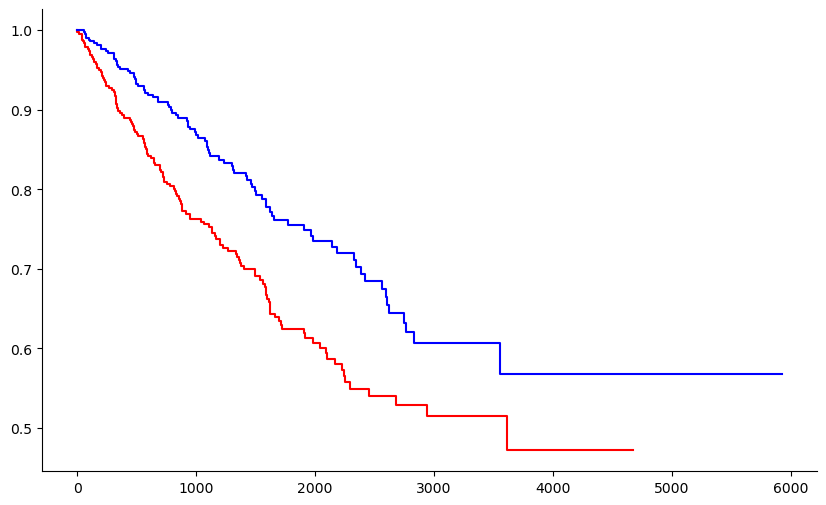

In [8]:
tissue = 'kidney'
surv_type = 'OS'
surv_time = f'{surv_type}.time'

tissue_df = tcga_info_df[tcga_info_df['tissue_type']==tissue]

get_survival_plot(tissue, tissue_df, surv_type, surv_time, surv_info_df)

### Figure 5. (b) Kaplan–Meier survival curves for the liver based on OS

p-value = 2.3e-03
Hazard Ratio = 1.73
95% CI = (1.21, 2.46)


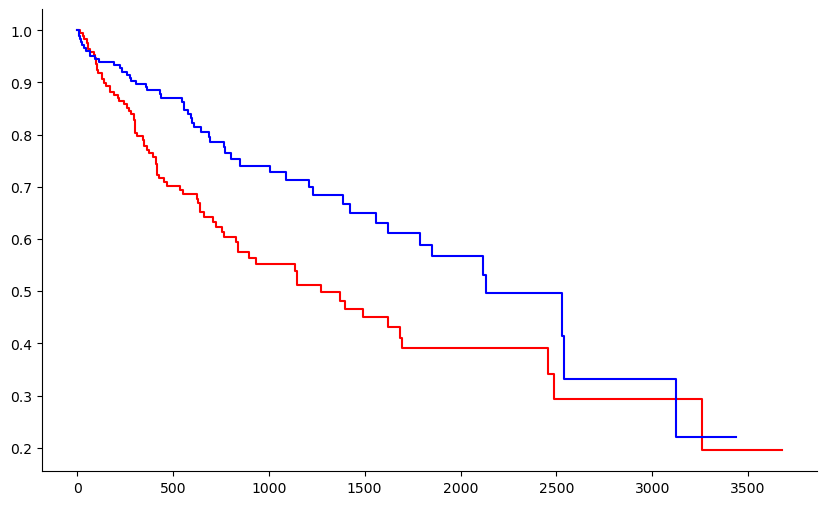

In [9]:
tissue = 'liver'
surv_type = 'OS'
surv_time = f'{surv_type}.time'

tissue_df = tcga_info_df[tcga_info_df['tissue_type']==tissue]

get_survival_plot(tissue, tissue_df, surv_type, surv_time, surv_info_df)

### Figure 5. (b) Kaplan–Meier survival curves for the bladder based on OS

p-value = 3.3e-03
Hazard Ratio = 1.57
95% CI = (1.16, 2.12)


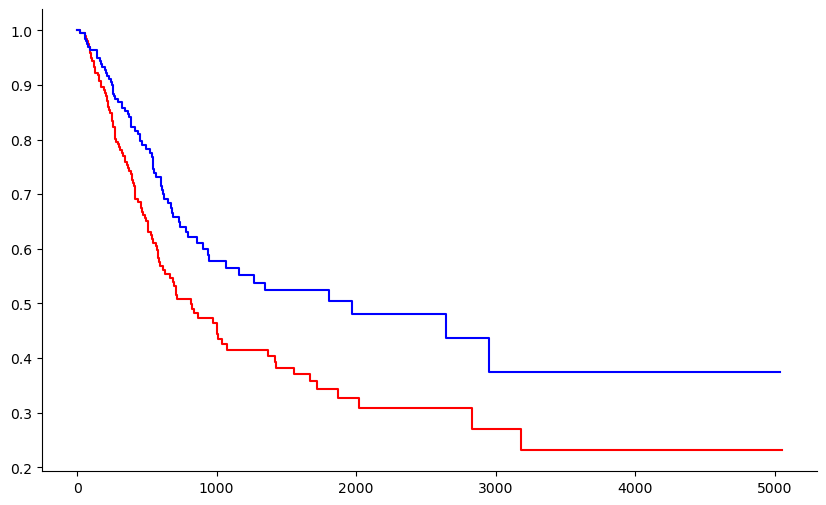

In [10]:
tissue = 'bladder'
surv_type = 'OS'
surv_time = f'{surv_type}.time'

tissue_df = tcga_info_df[tcga_info_df['tissue_type']==tissue]

get_survival_plot(tissue, tissue_df, surv_type, surv_time, surv_info_df)

### Figure 5. (b) Kaplan–Meier survival curves for the lung based on OS

p-value = 3.9e-03
Hazard Ratio = 1.34
95% CI = (1.10, 1.64)


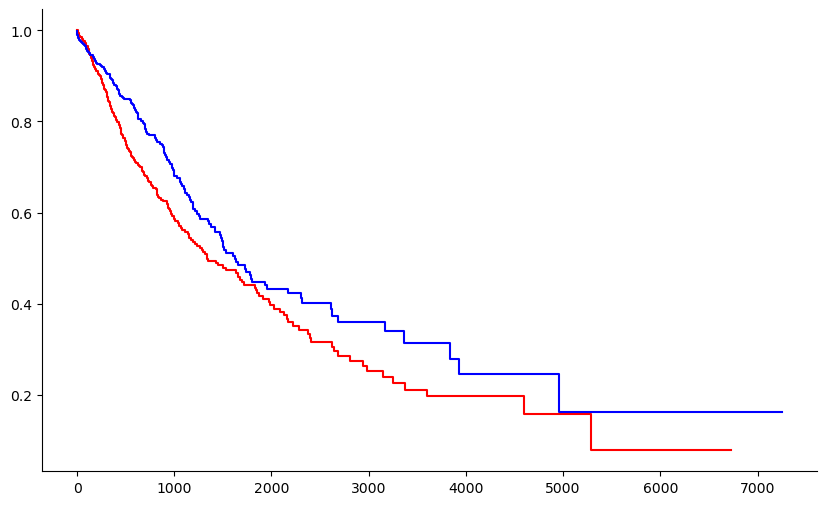

In [11]:
tissue = 'lung'
surv_type = 'OS'
surv_time = f'{surv_type}.time'

tissue_df = tcga_info_df[tcga_info_df['tissue_type']==tissue]

get_survival_plot(tissue, tissue_df, surv_type, surv_time, surv_info_df)